#**KLASIFIKASI MULTILABEL BATIK BESUREK BENGKULU**

#**Data Loading dan Library**

### Mount Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import Library

In [2]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.metrics import AUC


### Path Dataset

In [3]:
# Path dataset
train_csv_path = "/content/drive/MyDrive/Dataset/DataNA/train/_classes.csv"
test_csv_path = "/content/drive/MyDrive/Dataset/DataNA/test/_classes.csv"
valid_csv_path = "/content/drive/MyDrive/Dataset/DataNA/valid/_classes.csv"

# folder image dataset
train_img_folder = "/content/drive/MyDrive/Dataset/DataNA/train"
test_img_folder = "/content/drive/MyDrive/Dataset/DataNA/test"
valid_img_folder = "/content/drive/MyDrive/Dataset/DataNA/valid"

# Load CSV
train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)
valid_df = pd.read_csv(valid_csv_path)

# Validasi file gambar (hapus file yang tidak ada di folder)
train_df = train_df[train_df['filename'].apply(lambda x: os.path.exists(os.path.join(train_img_folder, x)))]
test_df = test_df[test_df['filename'].apply(lambda x: os.path.exists(os.path.join(test_img_folder, x)))]
valid_df = valid_df[valid_df['filename'].apply(lambda x: os.path.exists(os.path.join(valid_img_folder, x)))]


# **Data Understanding**


### Total Jumlah Data Train dan Test


In [4]:
print("Total gambar Train yang valid:", len(train_df))
print("Total gambar Val yang valid:", len(valid_df))
print("Total gambar Test yang valid:", len(test_df))

Total gambar Train yang valid: 2879
Total gambar Val yang valid: 823
Total gambar Test yang valid: 412


In [5]:
# Tampilkan 5 baris pertama dari train_df
train_df.head()


filename  Burung Kuau  \
0  20241030_153043_jpg.rf.43e2d4ab5bbb5d5180f14cd...            0   
1  IMG_3020_jpeg_jpg.rf.24996b83770bc3b4af6bca011...            0   
2  159_jpeg_jpg.rf.baadb4b98b70a0a80af2fa92d2cbe3...            0   
3  IMG_20250107_144109_jpg.rf.e558d8ef033cc5a74d3...            1   
4  IMG_20250107_144051_jpg.rf.d199bd6110fb111675a...            1   

   Burung Punai  Kaligrafi  Kaligrafi Lawas  Kembang Cempaka  Kembang Cengkeh  \
0             0          0                0                0                0   
1             0          0                0                0                0   
2             0          1                0                0                0   
3             0          1                0                0                0   
4             0          1                0                0                0   

   Kembang Melati  Pohon Hayat  Rafflesia  Relung Paku  Rembulan  
0               0            0          1            0         0  
1               0            0          1            0         0  
2               0            0          0            0         1  
3               0            1          0            0         0  
4               0            1          0            0         0

### Jumlah Data di Setiap Label

In [6]:
print("Distribusi Label Train:")
print(train_df.iloc[:, 1:].sum())

print("\nDistribusi Label Valid:")
print(valid_df.iloc[:, 1:].sum())

print("\nDistribusi Label Test:")
print(test_df.iloc[:, 1:].sum())


Distribusi Label Train:
Burung Kuau         690
Burung Punai        335
Kaligrafi          2124
Kaligrafi Lawas     382
Kembang Cempaka     365
Kembang Cengkeh     365
Kembang Melati      371
Pohon Hayat         348
Rafflesia           373
Relung Paku         335
Rembulan            363
dtype: int64

Distribusi Label Valid:
Burung Kuau        204
Burung Punai       123
Kaligrafi          627
Kaligrafi Lawas     90
Kembang Cempaka     98
Kembang Cengkeh     98
Kembang Melati      96
Pohon Hayat         97
Rafflesia          106
Relung Paku        123
Rembulan           106
dtype: int64

Distribusi Label Test:
Burung Kuau        107
Burung Punai        43
Kaligrafi          313
Kaligrafi Lawas     52
Kembang Cempaka     57
Kembang Cengkeh     57
Kembang Melati      54
Pohon Hayat         55
Rafflesia           47
Relung Paku         43
Rembulan            52
dtype: int64


In [7]:
import pandas as pd

# Menghitung jumlah sampel per label di setiap dataset
train_label_counts = train_df.iloc[:, 1:].sum()
valid_label_counts = valid_df.iloc[:, 1:].sum()
test_label_counts = test_df.iloc[:, 1:].sum()

# Membuat DataFrame untuk tampilan tabel
label_distribution_df = pd.DataFrame({
    "Train": train_label_counts,
    "Valid": valid_label_counts,
    "Test": test_label_counts,
    "Total": train_label_counts + valid_label_counts + test_label_counts  # Menambahkan kolom total
})

# Menampilkan tabel dengan format rapi
print("\n=== Distribusi Label di Dataset ===")
print(label_distribution_df)



=== Distribusi Label di Dataset ===
                 Train  Valid  Test  Total
Burung Kuau        690    204   107   1001
Burung Punai       335    123    43    501
Kaligrafi         2124    627   313   3064
Kaligrafi Lawas    382     90    52    524
Kembang Cempaka    365     98    57    520
Kembang Cengkeh    365     98    57    520
Kembang Melati     371     96    54    521
Pohon Hayat        348     97    55    500
Rafflesia          373    106    47    526
Relung Paku        335    123    43    501
Rembulan           363    106    52    521


### Grafik Distribusi Label

<ipython-input-8-3249943042>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y='Label Combination', x='Count', data=combo_counts, palette='magma')


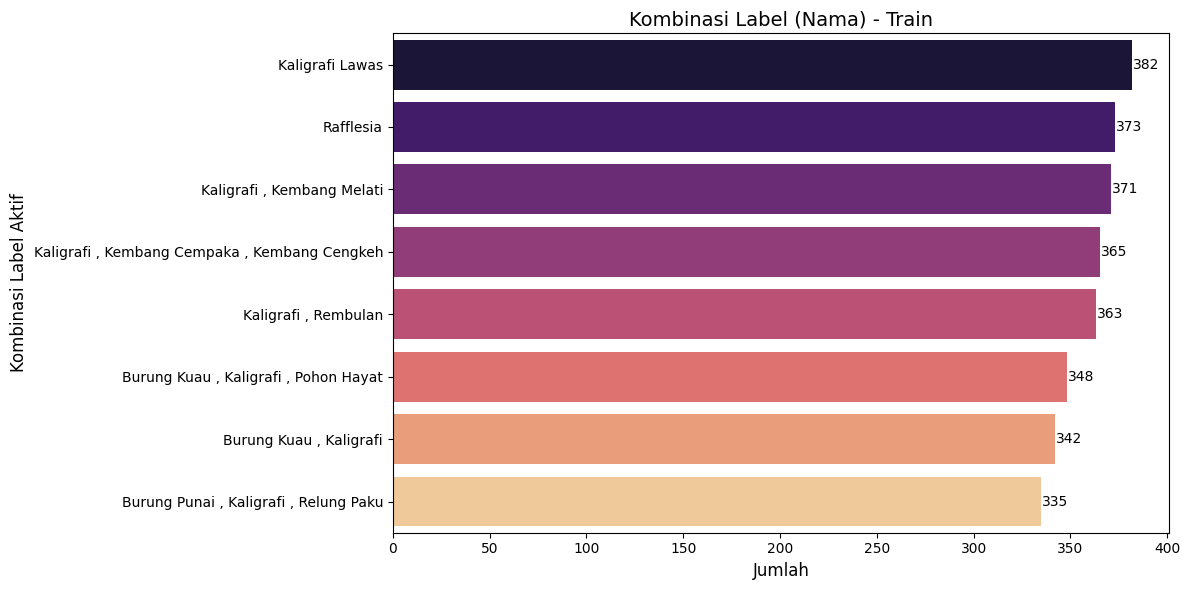

<ipython-input-8-3249943042>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y='Label Combination', x='Count', data=combo_counts, palette='magma')


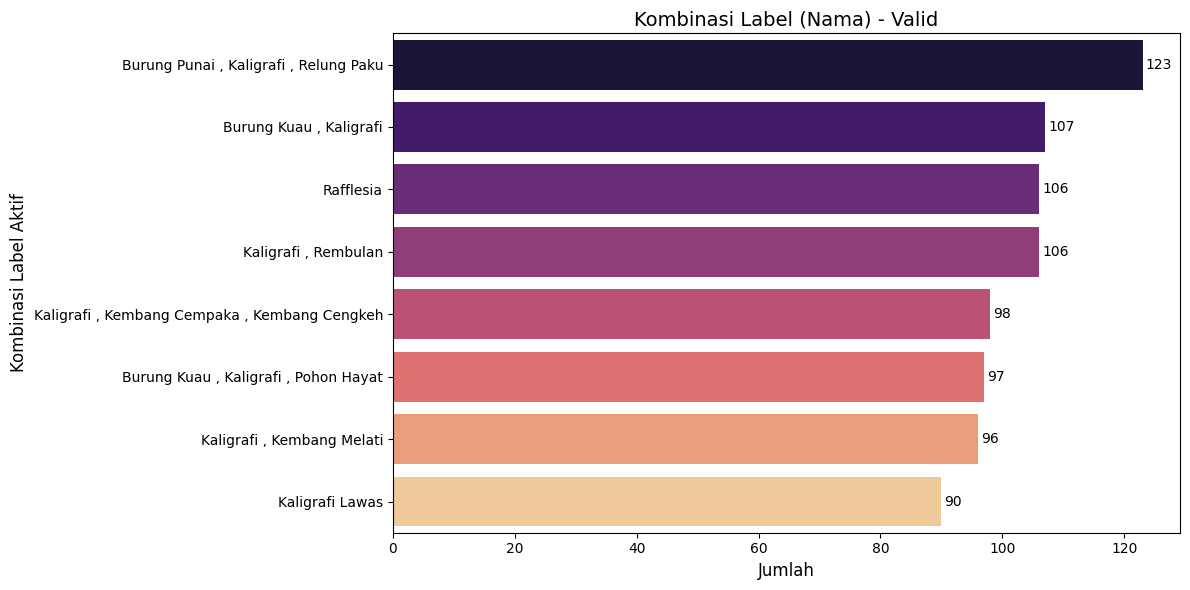

<ipython-input-8-3249943042>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y='Label Combination', x='Count', data=combo_counts, palette='magma')


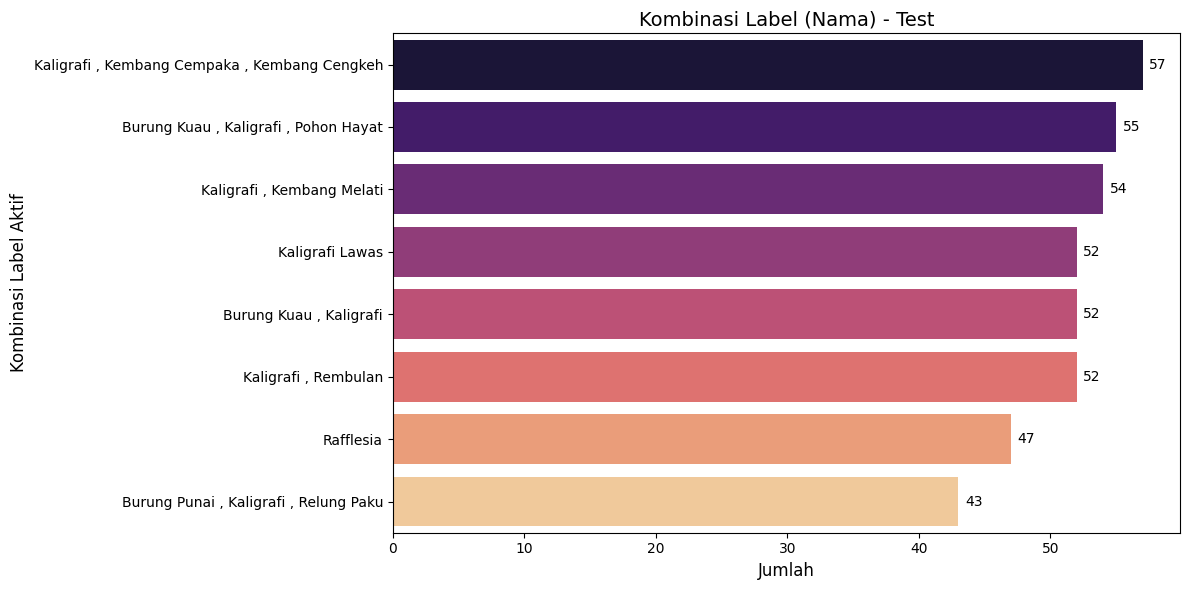

In [8]:
# Fungsi ambil kombinasi label pakai nama label
def get_named_label_combinations(df):
    label_cols = df.columns[1:]  # Ambil semua kolom label
    def combo_to_names(row):
        return ' , '.join([label for label, val in zip(label_cols, row) if val == 1]) or 'No Label'

    combos = df[label_cols].apply(combo_to_names, axis=1)
    combo_counts = combos.value_counts().reset_index()
    combo_counts.columns = ['Label Combination', 'Count']
    return combo_counts

# Fungsi buat plot + label jumlah
def plot_combinations(combo_counts, dataset_name):
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(y='Label Combination', x='Count', data=combo_counts, palette='magma')
    plt.title(f'Kombinasi Label (Nama) - {dataset_name}', fontsize=14)
    plt.xlabel('Jumlah', fontsize=12)
    plt.ylabel('Kombinasi Label Aktif', fontsize=12)

    # Tambahkan teks jumlah di ujung bar
    for i, (count) in enumerate(combo_counts['Count']):
        ax.text(count + 0.5, i, str(count), color='black', va='center', fontsize=10)

    plt.tight_layout()
    plt.show()

# Load dan filter ulang seperti biasa
train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)
valid_df = pd.read_csv(valid_csv_path)

train_df = train_df[train_df['filename'].apply(lambda x: os.path.exists(os.path.join(train_img_folder, x)))]
test_df = test_df[test_df['filename'].apply(lambda x: os.path.exists(os.path.join(test_img_folder, x)))]
valid_df = valid_df[valid_df['filename'].apply(lambda x: os.path.exists(os.path.join(valid_img_folder, x)))]

# Plot kombinasi label (dengan nama & jumlah) untuk tiap dataset
plot_combinations(get_named_label_combinations(train_df), "Train")
plot_combinations(get_named_label_combinations(valid_df), "Valid")
plot_combinations(get_named_label_combinations(test_df), "Test")


### Sampel Gambar dan Label

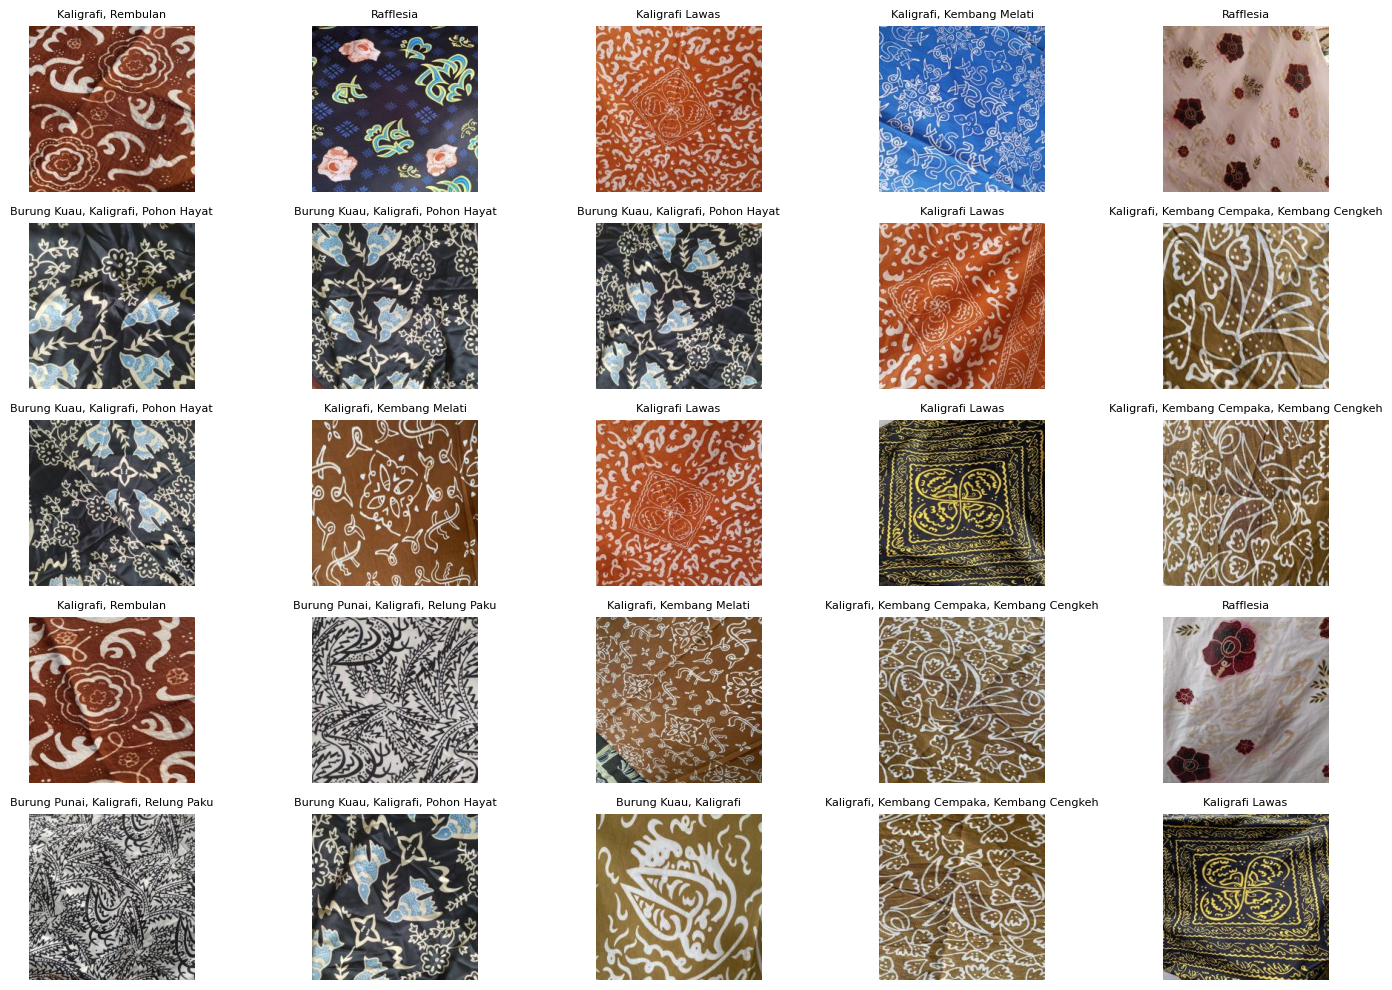

In [9]:
from PIL import Image


# Fungsi untuk konversi row label jadi teks label
def get_labels(row, label_cols):
    return ', '.join([label for label in label_cols if row[label] == 1]) or 'No Label'

# Ambil 25 sampel acak dari train_df
sample_df = train_df.sample(n=25, random_state=44).reset_index(drop=True)
label_cols = train_df.columns[1:]

# Plot gambar
plt.figure(figsize=(15, 10))
for i in range(25):
    img_path = os.path.join(train_img_folder, sample_df.loc[i, 'filename'])
    img = Image.open(img_path).convert('RGB')

    plt.subplot(5, 5, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(get_labels(sample_df.loc[i], label_cols), fontsize=8)

plt.tight_layout()
plt.show()


# **Data Preparation**

### Augmentasi Data Train

In [10]:
label_columns = train_df.columns[1:].tolist()

image_size = (224, 224)
batch_size = 32

# Normalisasi data
datagen = ImageDataGenerator(rescale=1.0 / 255)

### Data Generator



In [11]:
# Train generator
train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=train_img_folder,
    x_col='filename',
    y_col=label_columns,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='raw',
    shuffle=True,
)

# Validation generator
valid_generator = datagen.flow_from_dataframe(
    dataframe=valid_df,
    directory=valid_img_folder,
    x_col='filename',
    y_col=label_columns,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='raw',
    shuffle=False
)

# Test generator
test_generator = datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=test_img_folder,
    x_col='filename',
    y_col=label_columns,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='raw',
    shuffle=False
)

Found 2879 validated image filenames.
Found 823 validated image filenames.
Found 412 validated image filenames.


In [12]:
# Ambil satu batch sample dari train_generator
x_batch, y_batch = next(train_generator)

# Cek shape input dan label
print(f"Shape input batch: {x_batch.shape}")  # Harusnya (batch_size, 224, 224, 3)
print(f"Shape label batch: {y_batch.shape}")  # Harusnya (batch_size, jumlah_kelas)

Shape input batch: (32, 224, 224, 3)
Shape label batch: (32, 11)


# **Modeling**

### Pembuatan Model

In [ ]:
from tensorflow.keras.applications import InceptionResNetV2

# Load InceptionResNet tanpa fully connected layer atas (include_top=False)
base_model = InceptionResNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Freeze semua layer di InceptionResNet agar hanya bagian atas yang dilatih
base_model.trainable = False

# Custom head untuk multi-label classification
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
output = Dense(11, activation='sigmoid')(x)  # Multi-label classification

# Gabungkan base model + custom head
model = Model(inputs=base_model.input, outputs=output)


219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


### Compile Model

In [ ]:
# Path penyimpanan model di Google Drive
best_model_path = "/content/drive/MyDrive/Dataset/InceptionResNet_3.h5"

# Compile model dengan optimizer Adam dan AUC sebagai metric
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="binary_crossentropy",
    metrics=[tf.keras.metrics.AUC(name="auc")]
)

# Callbacks untuk early stopping, learning rate reduction, dan model checkpoint
callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-7),
    ModelCheckpoint(best_model_path, save_best_only=True, monitor="val_loss", mode="min")
]

# Tampilkan arsitektur model
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 111, 111,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 111, 111,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 111, 111,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 109, 109,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 109, 109,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 54, 54,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 54, 54,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 54, 54,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 52, 52,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 52, 52,    │          0 │ batch_normalizat

 Total params: 54,353,643 (207.34 MB)

 Trainable params: 16,907 (66.04 KB)

 Non-trainable params: 54,336,736 (207.28 MB)

### Train Model

In [ ]:
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=30,
    callbacks=callbacks
)
#13:19 -

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - auc: 0.6627 - loss: 0.6078 

90/90 ━━━━━━━━━━━━━━━━━━━━ 1759s 19s/step - auc: 0.6631 - loss: 0.6066 - val_auc: 0.8668 - val_loss: 0.3475 - learning_rate: 1.0000e-04
Epoch 2/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - auc: 0.8089 - loss: 0.3740

90/90 ━━━━━━━━━━━━━━━━━━━━ 41s 243ms/step - auc: 0.8091 - loss: 0.3738 - val_auc: 0.9427 - val_loss: 0.2831 - learning_rate: 1.0000e-04
Epoch 3/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - auc: 0.8829 - loss: 0.3088

90/90 ━━━━━━━━━━━━━━━━━━━━ 41s 246ms/step - auc: 0.8831 - loss: 0.3086 - val_auc: 0.9687 - val_loss: 0.2331 - learning_rate: 1.0000e-04
Epoch 4/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - auc: 0.9235 - loss: 0.2643

90/90 ━━━━━━━━━━━━━━━━━━━━ 22s 241ms/step - auc: 0.9236 - loss: 0.2642 - val_auc: 0.9796 - val_loss: 0.1977 - learning_rate: 1.0000e-04
Epoch 5/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - auc: 0.9510 - loss: 0.2230

90/90 ━━━━━━━━━━━━━━━━━━━━ 28s 315ms/step - auc: 0.9510 - loss: 0.2229 - val_auc: 0.9858 - val_loss: 0.1716 - learning_rate: 1.0000e-04
Epoch 6/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - auc: 0.9661 - loss: 0.1941

90/90 ━━━━━━━━━━━━━━━━━━━━ 24s 268ms/step - auc: 0.9661 - loss: 0.1941 - val_auc: 0.9891 - val_loss: 0.1517 - learning_rate: 1.0000e-04
Epoch 7/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - auc: 0.9754 - loss: 0.1722

90/90 ━━━━━━━━━━━━━━━━━━━━ 25s 273ms/step - auc: 0.9754 - loss: 0.1721 - val_auc: 0.9916 - val_loss: 0.1356 - learning_rate: 1.0000e-04
Epoch 8/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - auc: 0.9799 - loss: 0.1556

90/90 ━━━━━━━━━━━━━━━━━━━━ 26s 287ms/step - auc: 0.9799 - loss: 0.1556 - val_auc: 0.9937 - val_loss: 0.1222 - learning_rate: 1.0000e-04
Epoch 9/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - auc: 0.9840 - loss: 0.1443

90/90 ━━━━━━━━━━━━━━━━━━━━ 28s 312ms/step - auc: 0.9841 - loss: 0.1442 - val_auc: 0.9944 - val_loss: 0.1117 - learning_rate: 1.0000e-04
Epoch 10/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - auc: 0.9881 - loss: 0.1241

90/90 ━━━━━━━━━━━━━━━━━━━━ 39s 289ms/step - auc: 0.9881 - loss: 0.1241 - val_auc: 0.9955 - val_loss: 0.1027 - learning_rate: 1.0000e-04
Epoch 11/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - auc: 0.9897 - loss: 0.1210

90/90 ━━━━━━━━━━━━━━━━━━━━ 25s 272ms/step - auc: 0.9897 - loss: 0.1210 - val_auc: 0.9960 - val_loss: 0.0948 - learning_rate: 1.0000e-04
Epoch 12/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - auc: 0.9905 - loss: 0.1138

90/90 ━━━━━━━━━━━━━━━━━━━━ 39s 251ms/step - auc: 0.9905 - loss: 0.1137 - val_auc: 0.9969 - val_loss: 0.0877 - learning_rate: 1.0000e-04
Epoch 13/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - auc: 0.9925 - loss: 0.1041

90/90 ━━━━━━━━━━━━━━━━━━━━ 25s 281ms/step - auc: 0.9925 - loss: 0.1041 - val_auc: 0.9971 - val_loss: 0.0820 - learning_rate: 1.0000e-04
Epoch 14/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - auc: 0.9950 - loss: 0.0933

90/90 ━━━━━━━━━━━━━━━━━━━━ 28s 307ms/step - auc: 0.9949 - loss: 0.0933 - val_auc: 0.9976 - val_loss: 0.0767 - learning_rate: 1.0000e-04
Epoch 15/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - auc: 0.9955 - loss: 0.0878

90/90 ━━━━━━━━━━━━━━━━━━━━ 24s 267ms/step - auc: 0.9955 - loss: 0.0878 - val_auc: 0.9977 - val_loss: 0.0721 - learning_rate: 1.0000e-04
Epoch 16/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - auc: 0.9950 - loss: 0.0868

90/90 ━━━━━━━━━━━━━━━━━━━━ 27s 299ms/step - auc: 0.9950 - loss: 0.0868 - val_auc: 0.9981 - val_loss: 0.0678 - learning_rate: 1.0000e-04
Epoch 17/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - auc: 0.9961 - loss: 0.0799

90/90 ━━━━━━━━━━━━━━━━━━━━ 25s 278ms/step - auc: 0.9961 - loss: 0.0799 - val_auc: 0.9983 - val_loss: 0.0640 - learning_rate: 1.0000e-04
Epoch 18/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - auc: 0.9962 - loss: 0.0770

90/90 ━━━━━━━━━━━━━━━━━━━━ 26s 283ms/step - auc: 0.9962 - loss: 0.0770 - val_auc: 0.9984 - val_loss: 0.0604 - learning_rate: 1.0000e-04
Epoch 19/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - auc: 0.9975 - loss: 0.0701

90/90 ━━━━━━━━━━━━━━━━━━━━ 29s 317ms/step - auc: 0.9975 - loss: 0.0701 - val_auc: 0.9986 - val_loss: 0.0577 - learning_rate: 1.0000e-04
Epoch 20/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - auc: 0.9971 - loss: 0.0687

90/90 ━━━━━━━━━━━━━━━━━━━━ 25s 271ms/step - auc: 0.9971 - loss: 0.0687 - val_auc: 0.9987 - val_loss: 0.0546 - learning_rate: 1.0000e-04
Epoch 21/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - auc: 0.9974 - loss: 0.0656

90/90 ━━━━━━━━━━━━━━━━━━━━ 24s 266ms/step - auc: 0.9974 - loss: 0.0656 - val_auc: 0.9988 - val_loss: 0.0521 - learning_rate: 1.0000e-04
Epoch 22/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - auc: 0.9975 - loss: 0.0638

90/90 ━━━━━━━━━━━━━━━━━━━━ 39s 245ms/step - auc: 0.9975 - loss: 0.0638 - val_auc: 0.9989 - val_loss: 0.0497 - learning_rate: 1.0000e-04
Epoch 23/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - auc: 0.9982 - loss: 0.0595

90/90 ━━━━━━━━━━━━━━━━━━━━ 46s 300ms/step - auc: 0.9982 - loss: 0.0595 - val_auc: 0.9990 - val_loss: 0.0478 - learning_rate: 1.0000e-04
Epoch 24/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - auc: 0.9984 - loss: 0.0550

90/90 ━━━━━━━━━━━━━━━━━━━━ 27s 296ms/step - auc: 0.9984 - loss: 0.0550 - val_auc: 0.9991 - val_loss: 0.0454 - learning_rate: 1.0000e-04
Epoch 25/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - auc: 0.9979 - loss: 0.0579

90/90 ━━━━━━━━━━━━━━━━━━━━ 24s 268ms/step - auc: 0.9979 - loss: 0.0578 - val_auc: 0.9991 - val_loss: 0.0439 - learning_rate: 1.0000e-04
Epoch 26/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - auc: 0.9987 - loss: 0.0513

90/90 ━━━━━━━━━━━━━━━━━━━━ 25s 279ms/step - auc: 0.9987 - loss: 0.0513 - val_auc: 0.9992 - val_loss: 0.0420 - learning_rate: 1.0000e-04
Epoch 27/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - auc: 0.9978 - loss: 0.0569

90/90 ━━━━━━━━━━━━━━━━━━━━ 39s 254ms/step - auc: 0.9978 - loss: 0.0569 - val_auc: 0.9993 - val_loss: 0.0404 - learning_rate: 1.0000e-04
Epoch 28/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - auc: 0.9987 - loss: 0.0481

90/90 ━━━━━━━━━━━━━━━━━━━━ 25s 282ms/step - auc: 0.9987 - loss: 0.0481 - val_auc: 0.9993 - val_loss: 0.0387 - learning_rate: 1.0000e-04
Epoch 29/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - auc: 0.9989 - loss: 0.0455

90/90 ━━━━━━━━━━━━━━━━━━━━ 39s 263ms/step - auc: 0.9989 - loss: 0.0455 - val_auc: 0.9993 - val_loss: 0.0374 - learning_rate: 1.0000e-04
Epoch 30/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - auc: 0.9988 - loss: 0.0456

90/90 ━━━━━━━━━━━━━━━━━━━━ 39s 246ms/step - auc: 0.9988 - loss: 0.0457 - val_auc: 0.9994 - val_loss: 0.0360 - learning_rate: 1.0000e-04


### Plotting

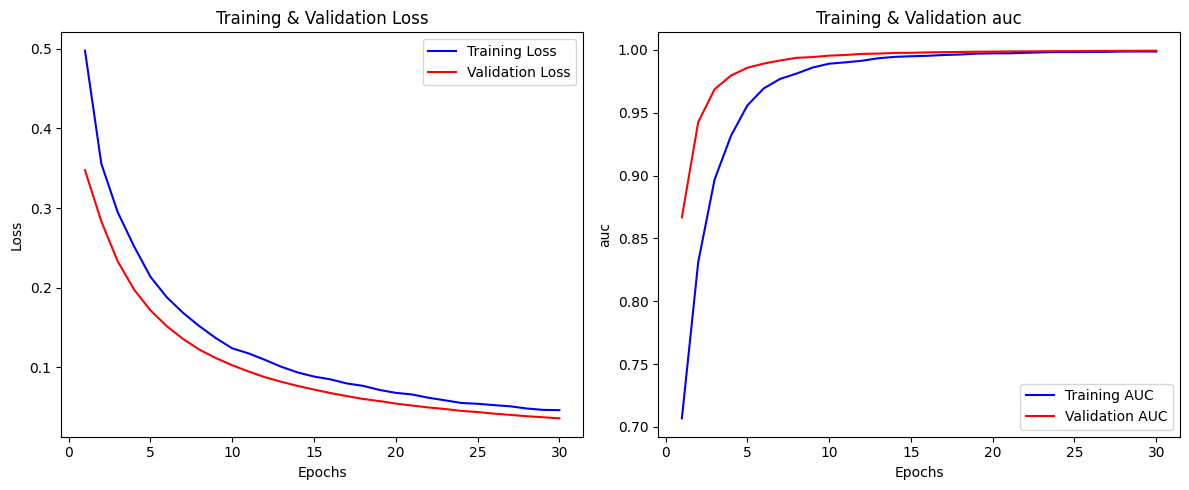

In [ ]:
# Ambil data dari history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_auc = history.history['auc']
val_auc = history.history['val_auc']

epochs = range(1, len(train_loss) + 1)

# Plot Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

# Plot AUC
plt.subplot(1, 2, 2)
plt.plot(epochs, train_auc, 'b-', label='Training AUC')
plt.plot(epochs, val_auc, 'r-', label='Validation AUC')
plt.xlabel('Epochs')
plt.ylabel('auc')
plt.title('Training & Validation auc')
plt.legend()

plt.tight_layout()
plt.show()


# **Evaluasi**

In [ ]:
model.save("/content/drive/MyDrive/Dataset/InceptionResNet_3.h5")

NameError: name 'model' is not defined

In [ ]:
model.save("/content/drive/MyDrive/Dataset/InceptionResNet_3.keras")


### Prediksi dengan test set

In [13]:
import h5py

# Cek isi file H5 tanpa load model
with h5py.File("/content/drive/MyDrive/Dataset/InceptionResNet_3.h5", "r") as f:
    print("Layers dalam model:")
    for key in f.keys():
        print(key)


Layers dalam model:
model_weights
optimizer_weights


In [14]:
# Load model
best_model_path = "/content/drive/MyDrive/Dataset/InceptionResNet_3.keras"
model = tf.keras.models.load_model(best_model_path)

# Prediksi pada test set
y_pred_prob = model.predict(test_generator)
y_pred = (y_pred_prob > 0.5).astype(int)

test_loss, test_auc = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test AUC: {test_auc:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 4 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13/13 ━━━━━━━━━━━━━━━━━━━━ 184s 13s/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 149s 10s/step - auc: 0.9997 - loss: 0.0361
Test Loss: 0.0362
Test AUC: 0.9996


### Classification Report

In [16]:
# Ambil label asli
y_true = test_df.iloc[:, 1:].values  # Mengambil nilai label dari dataframe
labels = test_df.columns[1:].tolist()

# Classification Report
print(classification_report(y_true, y_pred, target_names=labels))

                 precision    recall  f1-score   support

    Burung Kuau       1.00      0.89      0.94       107
   Burung Punai       1.00      1.00      1.00        43
      Kaligrafi       1.00      1.00      1.00       313
Kaligrafi Lawas       1.00      0.94      0.97        52
Kembang Cempaka       1.00      1.00      1.00        57
Kembang Cengkeh       1.00      1.00      1.00        57
 Kembang Melati       1.00      0.96      0.98        54
    Pohon Hayat       1.00      0.95      0.97        55
      Rafflesia       1.00      0.96      0.98        47
    Relung Paku       1.00      1.00      1.00        43
       Rembulan       1.00      0.92      0.96        52

      micro avg       1.00      0.97      0.98       880
      macro avg       1.00      0.97      0.98       880
   weighted avg       1.00      0.97      0.98       880
    samples avg       0.99      0.97      0.97       880



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Confussion Matrix

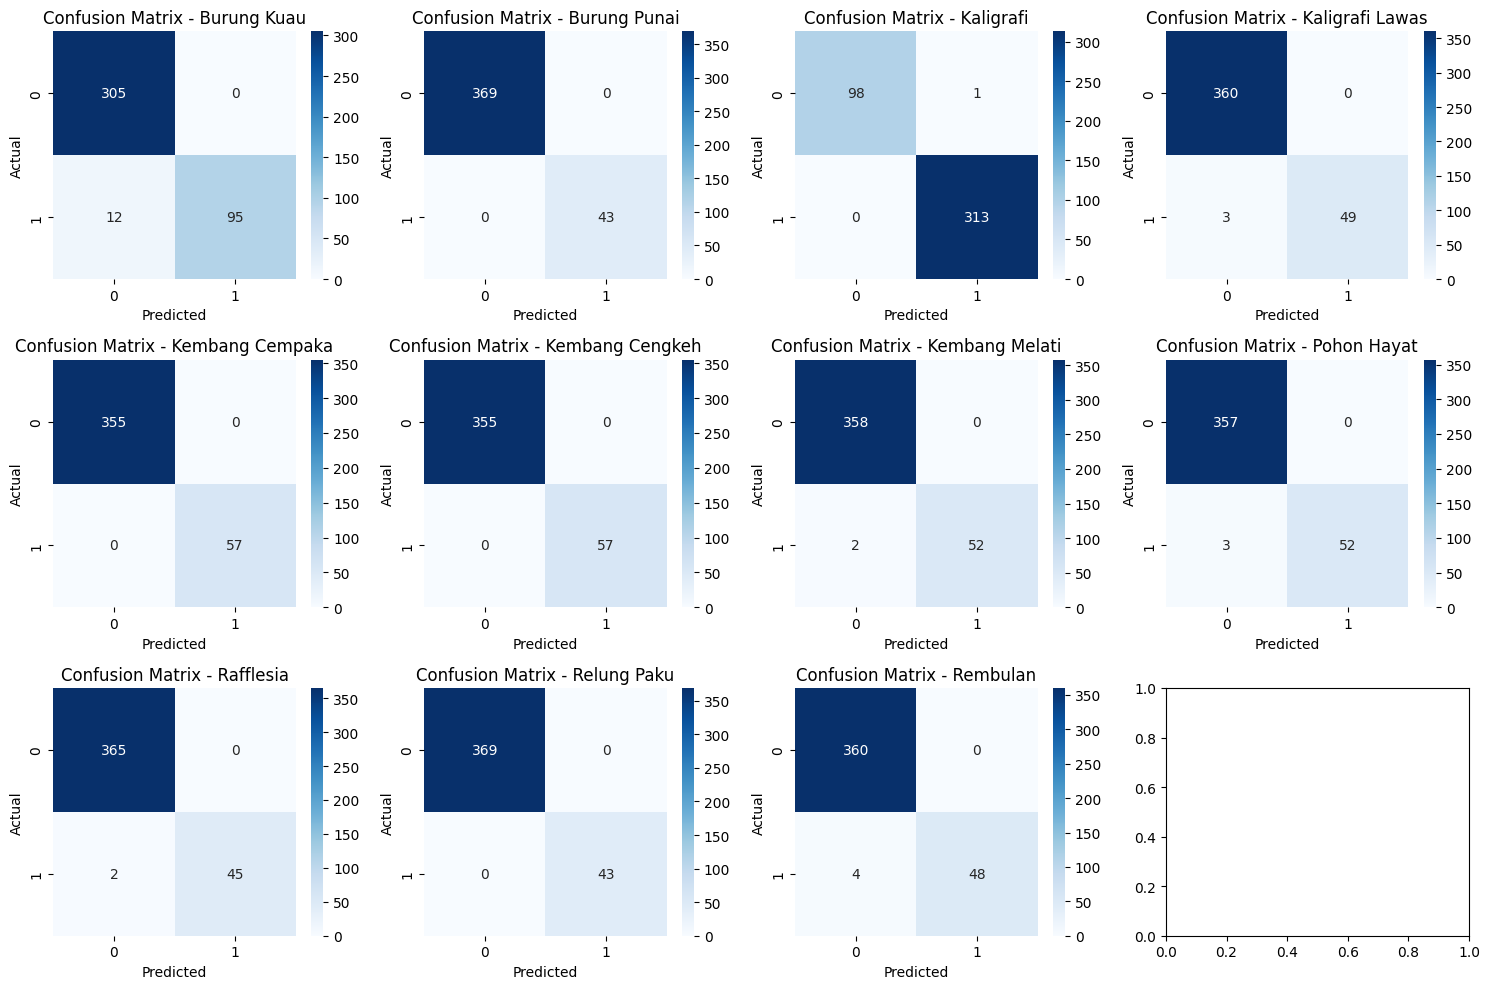

In [17]:
# Cell 3: Confusion Matrix per Label
from sklearn.metrics import classification_report, multilabel_confusion_matrix

cm_list = multilabel_confusion_matrix(y_true, y_pred)
fig, axes = plt.subplots(3, 4, figsize=(15, 10))
axes = axes.ravel()

for i, (label, cm) in enumerate(zip(labels, cm_list)):
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[i])
    axes[i].set_title(f'Confusion Matrix - {label}')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

plt.tight_layout()
plt.show()


### Menampilkan Gambar dengan Label dan Prediksi

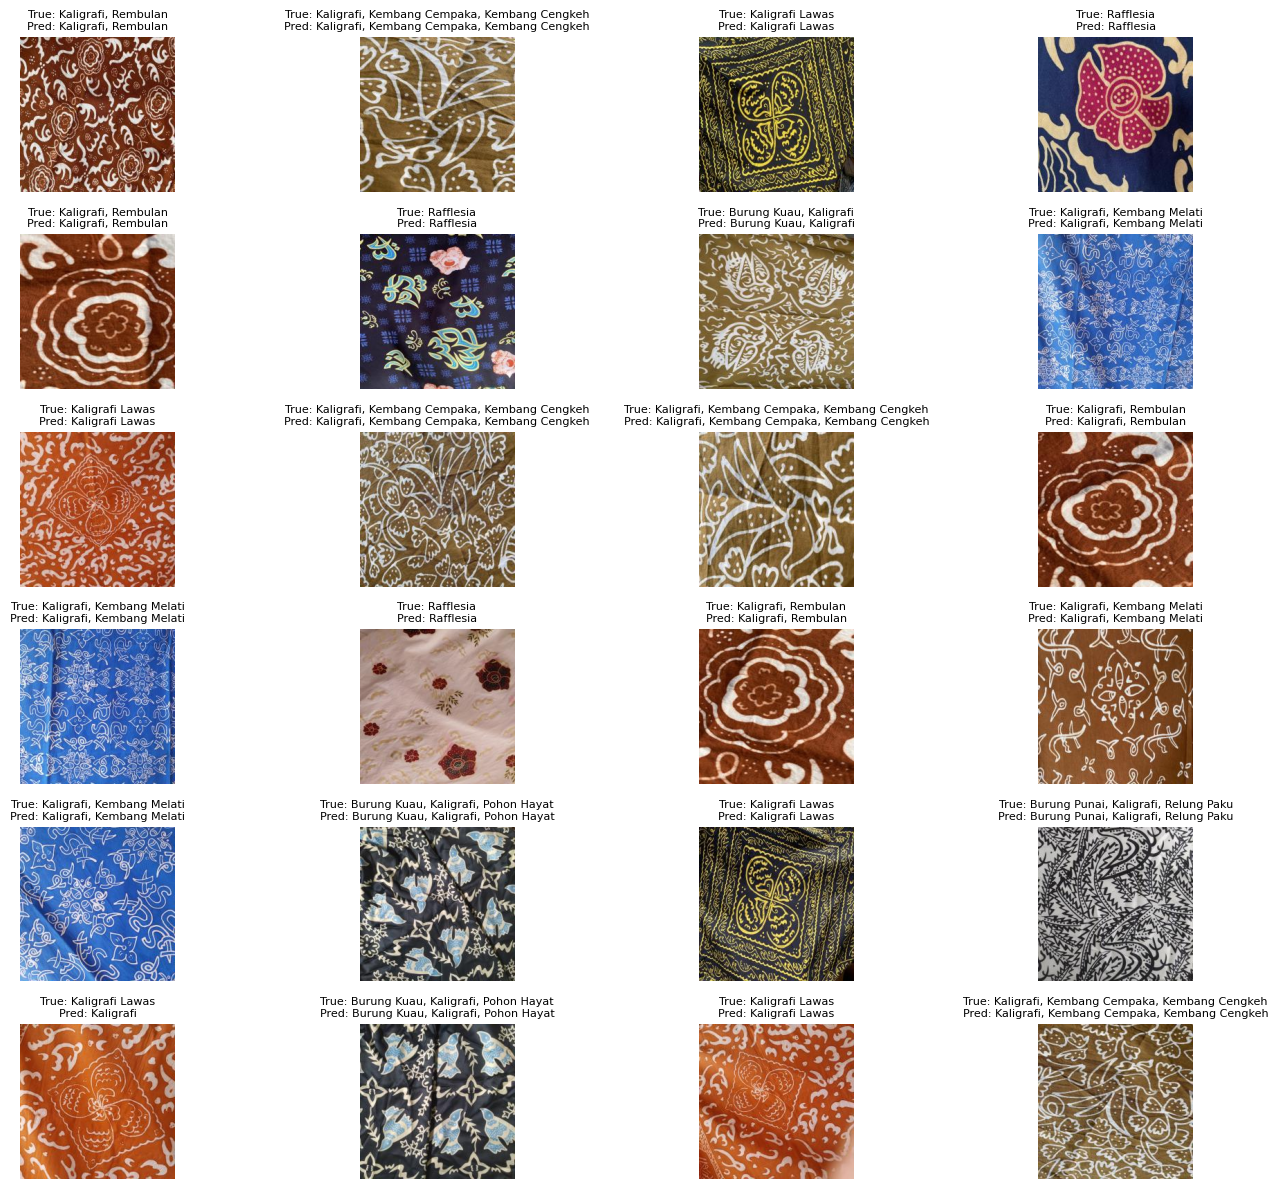

In [18]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Load model
best_model_path = "/content/drive/MyDrive/Dataset/InceptionResNet_3.keras"
model = tf.keras.models.load_model(best_model_path, compile=False)

# Ambil sampel data
num_samples = 24
sample_df = test_df.sample(num_samples, random_state=42)

# Buat plot
fig, axes = plt.subplots(6, 4, figsize=(15, 12))
axes = axes.ravel()

for i, (index, row) in enumerate(sample_df.iterrows()):
    img_path = os.path.join(test_img_folder, row["filename"])

    if os.path.exists(img_path):  # Pastikan file ada
        img = load_img(img_path, target_size=(224, 224))
        img_array = np.expand_dims(img_to_array(img) / 255.0, axis=0)

        # Prediksi
        y_pred_prob = model.predict(img_array, verbose=0)
        y_pred = (y_pred_prob > 0.5).astype(int).flatten()  # Perbaikan di sini
        y_true = row[1:].values.astype(int)

        # Label asli & prediksi
        true_labels = [label for label, t in zip(test_df.columns[1:], y_true) if t == 1]
        pred_labels = [label for label, p in zip(test_df.columns[1:], y_pred) if p == 1]

        # Plot gambar
        axes[i].imshow(img)
        axes[i].axis("off")
        axes[i].set_title(f"True: {', '.join(true_labels)}\nPred: {', '.join(pred_labels)}", fontsize=8)

# Atur tata letak agar lebih rapi
plt.subplots_adjust(hspace=1.0, wspace=0.5)
plt.tight_layout()
plt.show()


### Performa Metrik untuk Valid Data

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 4 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


26/26 ━━━━━━━━━━━━━━━━━━━━ 382s 14s/step

=== Model Performance on Validation Set ===
   Accuracy  Precision    Recall       AUC     Kappa  F1_score  Final_score
0  0.945322   0.994842  0.973022  0.999322  0.939971  0.983554     0.974282


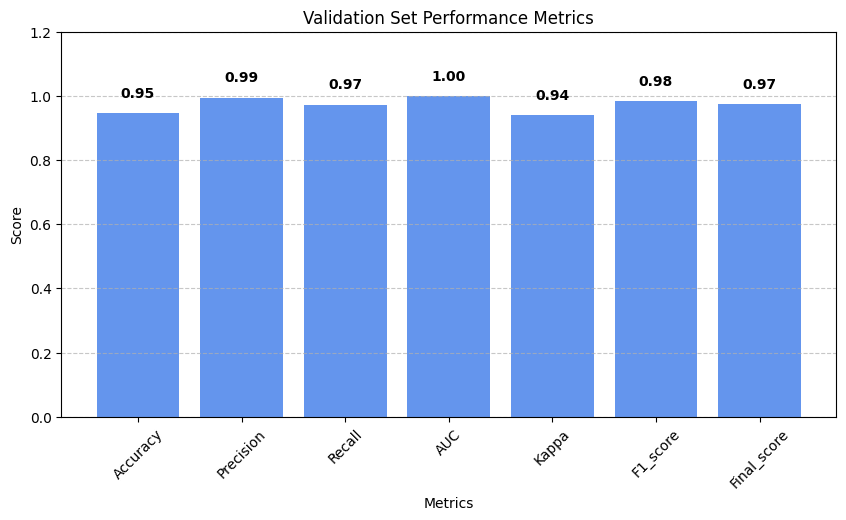

In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, cohen_kappa_score

# Load model yang telah dilatih
model_path = "/content/drive/MyDrive/Dataset/InceptionResNet_3.keras"
model = tf.keras.models.load_model(model_path)


y_true_valid = valid_generator.labels  # Label asli dari valid set
y_pred_probs_valid = model.predict(valid_generator)  # Probabilitas prediksi

# Konversi ke label biner (untuk evaluasi multi-label)
y_pred_valid = (y_pred_probs_valid >= 0.5).astype(int)  # Threshold 0.5

# Menghitung metrik evaluasi
accuracy_valid = accuracy_score(y_true_valid, y_pred_valid)
precision_valid = precision_score(y_true_valid, y_pred_valid, average='macro')
recall_valid = recall_score(y_true_valid, y_pred_valid, average='macro')
f1_valid = f1_score(y_true_valid, y_pred_valid, average='macro')
auc_valid = roc_auc_score(y_true_valid, y_pred_probs_valid, average='macro')
kappa_valid = cohen_kappa_score(y_true_valid.argmax(axis=1), y_pred_valid.argmax(axis=1))

# **Menghitung Final Score sebagai rata-rata dari F1-score, Kappa, dan AUC**
final_score_valid = np.mean([f1_valid, kappa_valid, auc_valid])

# Membuat tabel hasil evaluasi untuk validasi set
metrics_valid = {
    "Accuracy": [accuracy_valid],
    "Precision": [precision_valid],
    "Recall": [recall_valid],
    "AUC": [auc_valid],
    "Kappa": [kappa_valid],
    "F1_score": [f1_valid],
    "Final_score": [final_score_valid]  # Final score dari rata-rata F1-score, Kappa, dan AUC
}


df_valid = pd.DataFrame(metrics_valid)
print("\n=== Model Performance on Validation Set ===")
print(df_valid)

# **Visualisasi bar plot
plt.figure(figsize=(10, 5))
bars = plt.bar(df_valid.columns, df_valid.loc[0], color='cornflowerblue')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2,
             yval + 0.05,
             f"{yval:.2f}",
             ha='center',
             fontsize=10,
             fontweight='bold')

plt.xlabel("Metrics")
plt.ylabel("Score")
plt.title("Validation Set Performance Metrics")
plt.ylim(0, 1.2)  # **Batas atas diperbesar agar ada ruang untuk teks**
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)  # **Menambah grid horizontal untuk estetika**
plt.show()


### Performa Metrik Untuk Test Data

13/13 ━━━━━━━━━━━━━━━━━━━━ 134s 10s/step

=== Model Performance on Test Set ===
   Accuracy  Precision    Recall       AUC     Kappa  F1_score  Final_score
0  0.941748    0.99971  0.965373  0.999729  0.943494  0.981877     0.975033


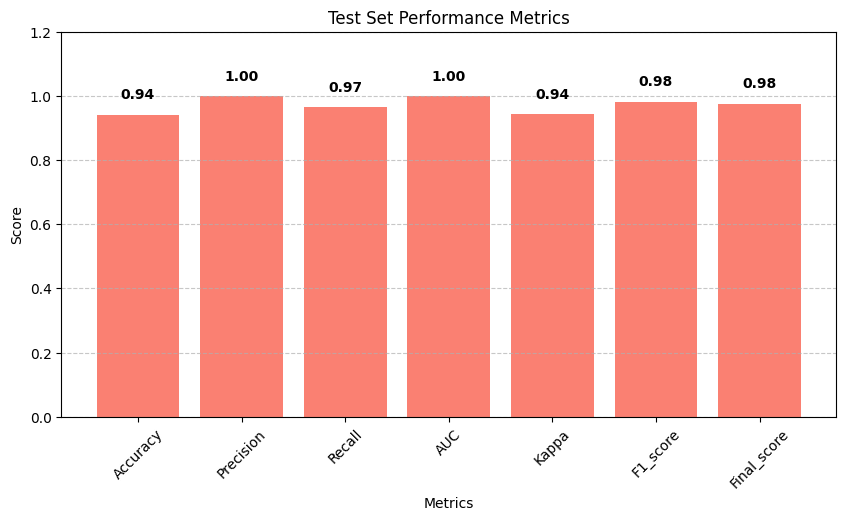

In [20]:
# Pastikan test_generator sudah dibuat sebelumnya
y_true_test = test_generator.labels  # Label asli dari test set
y_pred_probs_test = model.predict(test_generator)  # Probabilitas prediksi

# Konversi ke label biner (untuk evaluasi multi-label)
y_pred_test = (y_pred_probs_test >= 0.5).astype(int)  # Threshold 0.5

# Menghitung metrik evaluasi
accuracy_test = accuracy_score(y_true_test, y_pred_test)
precision_test = precision_score(y_true_test, y_pred_test, average='macro')
recall_test = recall_score(y_true_test, y_pred_test, average='macro')
f1_test = f1_score(y_true_test, y_pred_test, average='macro')
auc_test = roc_auc_score(y_true_test, y_pred_probs_test, average='macro')
kappa_test = cohen_kappa_score(y_true_test.argmax(axis=1), y_pred_test.argmax(axis=1))

# **Menghitung Final Score sebagai rata-rata semua metrik**
final_score_test = np.mean([f1_test, kappa_test, auc_test])

# Membuat tabel hasil evaluasi untuk test set
metrics_test = {
    "Accuracy": [accuracy_test],
    "Precision": [precision_test],
    "Recall": [recall_test],
    "AUC": [auc_test],
    "Kappa": [kappa_test],
    "F1_score": [f1_test],
    "Final_score": [final_score_test]  # Final score dari rata-rata F1-score, Kappa, dan AUC
}

df_test = pd.DataFrame(metrics_test)
print("\n=== Model Performance on Test Set ===")
print(df_test)

# **Visualisasi bar plot dengan nilai metrik di atas batang (jarak lebih rapi)**
plt.figure(figsize=(10, 5))
bars = plt.bar(df_test.columns, df_test.loc[0], color='salmon')

# Menambahkan nilai di atas setiap batang dengan jarak lebih rapi
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2,
             yval + 0.05,  # **Menambah jarak dari batang agar lebih rapi**
             f"{yval:.2f}",
             ha='center',
             fontsize=10,
             fontweight='bold')

plt.xlabel("Metrics")
plt.ylabel("Score")
plt.title("Test Set Performance Metrics")
plt.ylim(0, 1.2)  # **Batas atas diperbesar agar ada ruang untuk teks**
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)  # **Menambah grid horizontal untuk estetika**
plt.show()


# **Prediksi dengan Interface**

In [ ]:
!pip install gradio

In [ ]:
import gradio as gr
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Load model
best_model_path = "/content/drive/MyDrive/Dataset/InceptionResNet_3.h5"
model = tf.keras.models.load_model(best_model_path, compile=False)

# Label kategori
labels = ['Burung Kuau', 'Burung Punai', 'Kaligrafi', 'Kaligrafi Lawas', 'Kembang Cempaka',
          'Kembang Cengkeh', 'Kembang Melati', 'Pohon Hayat', 'Rafflesia', 'Relung Paku', 'Rembulan']

# Fungsi prediksi
def predict(image):
    img = image.resize((224, 224))  # Resize gambar
    img_array = np.expand_dims(img_to_array(img) / 255.0, axis=0)  # Normalisasi

    y_pred_prob = model.predict(img_array, verbose=0)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()

    pred_labels = [label for label, p in zip(labels, y_pred) if p == 1]
    return ', '.join(pred_labels) if pred_labels else "Tidak terdeteksi"

# Setup Gradio
iface = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="pil"),
    outputs=gr.Textbox(label="Hasil Prediksi"),
    title="Klasifikasi Motif Batik Besurek",
    description="Upload gambar batik besurek, lalu lihat hasil prediksi model!"
)

# Jalankan aplikasi
iface.launch()

# **Prediksi dengan Input Data Internet**

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from google.colab import files
import IPython.display as display
from PIL import Image

# Load model
best_model_path = "/content/drive/MyDrive/Dataset/InceptionResNet_3.h5"
model = tf.keras.models.load_model(best_model_path, compile=False)

# Label kategori
labels = ['Burung Kuau', 'Burung Punai', 'Kaligrafi', 'Kaligrafi Lawas', 'Kembang Cempaka',
          'Kembang Cengkeh', 'Kembang Melati', 'Pohon Hayat', 'Rafflesia', 'Relung Paku', 'Rembulan']

# Fungsi prediksi
def predict(image_path):
    img = load_img(image_path, target_size=(224, 224))  # Resize gambar
    img_array = np.expand_dims(img_to_array(img) / 255.0, axis=0)  # Normalisasi

    y_pred_prob = model.predict(img_array, verbose=0)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()

    pred_labels = [label for label, p in zip(labels, y_pred) if p == 1]
    return ', '.join(pred_labels) if pred_labels else "Tidak terdeteksi"

# Loop untuk upload & prediksi
while True:
    print("\nSilakan upload gambar untuk prediksi:")
    uploaded = files.upload()

    if uploaded:
        image_path = list(uploaded.keys())[0]
        img = Image.open(image_path)

        # Tampilkan gambar
        display.display(img)

        # Prediksi
        hasil_prediksi = predict(image_path)
        print("\n=== Hasil Prediksi ===")
        print(hasil_prediksi)

    # Tanya apakah ingin upload lagi
    lanjut = input("\nIngin upload gambar lain? (ya/tidak): ").strip().lower()
    if lanjut != "ya":
        print("\nTerima kasih! Selesai.")
        break
